In [596]:
import cmocean.cm as cm
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

Our model system is a simple flat bottom box with a single layer of fluid.  The shallow water equation system.  We will neglect any explicit viscosity, and the nonlinear advection terms but include the Coriolis Force.  If your research is generally too small to feel the Coriolis force, set your box small and it will have a negligible impact.  We will force the fluid with a Gaussian addition (rain or runoff) in the centre of the domain.

So the governing equations are
\begin{equation}
\frac{\partial u}{\partial t} - f v = - g \frac{\partial \eta}{\partial x}
\end{equation}
\begin{equation}
\frac{\partial v}{\partial t} + f u = - g \frac{\partial \eta}{\partial y}
\end{equation}
\begin{equation}
\frac{\partial \eta}{\partial t} + H \left( \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} \right) = 0
\end{equation}
where $(u, v)$ is the horizontal velocity in $(x, y)$ directions, $f$ is the Coriolis parameter, $g = 9.8$m s$^{-2}$ is the acceleration due to gravity and $H$ is the depth of the fluid. 

The box has width and length $length$ and depth $H$.

In [597]:
# Nice small system, keep npts small
npts = 32
# Standard Parameters
g = 9.8 # m/s2
f = 1e-4 # s-1: good for mid-latitudes
# Choose your Box Size
length = 2000e3 # m
H = 200 # m

We will solve the system on an Arakawa C-Grid with the u-velocity staggered 1/2 grid point in x from the $\eta$ point and the v-velocity staggered 1/2 grid point in y.  Like this: 

v   
|   
|   
$\eta$ $-$ $-$ u   

We will use an explicit leap-frog scheme and so must choose our timestep, $dt$, small enough to meet the CFL condition. The leap-frog scheme requires two-previous steps so we will have two sets of arrays


In [598]:
# Derived Quantities
dx = length/npts
wavespeed = np.sqrt(g*H)
dt = 0.25*dx/wavespeed

In [599]:
# Set up our arrays
def set_arrays(npts):
    eta_now = np.zeros((npts, npts))
    u_now = np.zeros_like(eta_now)
    v_now = np.zeros_like(eta_now)
    eta_prev = np.zeros_like(eta_now)
    u_prev = np.zeros_like(eta_now)
    v_prev = np.zeros_like(eta_now)
    eta_next = np.zeros_like(eta_now)
    u_next = np.zeros_like(eta_now)
    v_next = np.zeros_like(eta_now)
    return eta_now, u_now, v_now, eta_prev, u_prev, v_prev, eta_next, u_next, v_next

In [600]:
# Initialize
def initialize(magnitude, gausshalfwidth, eta):
    eta_init = np.zeros_like(eta)
    n = eta.shape[0]
    half = (n-1)/3.
    islice = np.arange(n)
    jslice = np.arange(n)
    ijslice, jislice = np.meshgrid(islice, jslice)
    eta_init = magnitude*np.exp(-((ijslice-half)**2+(jislice-half)**2)/(2*gausshalfwidth**2))
    return eta_init

In [601]:
def initialize_simple(magnitude, gausshalfwidth, eta):
    eta_init = np.zeros_like(eta)
    n = eta.shape[0]
    half = (n-1)/3.
    islice = np.arange(n)
    jslice = np.arange(n)
    ijslice, jislice = np.meshgrid(islice, jslice)
    eta_init = magnitude*np.exp(-((jislice-half)**2)/(2*gausshalfwidth**2))
    return eta_init

In [602]:
# Euler Step
def euler(eta, u, v, idt, f, g, H, dx):
    n = eta.shape[0]
    eta_next = zeros_like(eta)
    u_next = zeros_like(eta)
    v_next = zeros_like(eta)
    eta_next[1:, 1:] = eta[1:, 1:] + idt * (-H) * (u[1:, 1:] - u[:-1, 1:] + v[1:, 1:] - v[1:, :-1])/dx 
    u_next[:-1, 1:] = u[:-1, 1:] + idt * (- g * (eta[1:, 1:] - eta[:-1, 1:])/dx
                                              + 0.25 * f *(v[:-1, 1:] + v[1:, 1:] + v[:-1, :-1] + v[1:, :-1]))
    v_next[1:, :-1] = v[1:, :-1] + idt * (- g * (eta[1:, 1:] - eta[1:, :-1])/dx
                                              - 0.25 * f *(u[1:, :-1] + u[:-1, :-1] + u[1:, 1:] + u[:-1, 1:]))
    return eta_next, u_next, v_next

In [603]:
# Leap-frog Step
def leapfrog(eta, u, v, etap, up, vp, idt, f, g, H, dx):
    eta_next = zeros_like(eta)
    u_next = zeros_like(eta)
    v_next = zeros_like(eta)
    eta_next[1:, 1:] = etap[1:, 1:] + idt * (-H) * (u[1:, 1:] - u[:-1, 1:] + v[1:, 1:] - v[1:, :-1])/dx 
    u_next[:-1, 1:] = up[:-1, 1:] + idt * (- g * (eta[1:, 1:] - eta[:-1, 1:])/dx
                                              + 0.25 * f *(v[:-1, 1:] + v[1:, 1:] + v[:-1, :-1] + v[1:, :-1]))
    v_next[1:, :-1] = vp[1:, :-1] + idt * (- g * (eta[1:, 1:] - eta[1:, :-1])/dx
                                              - 0.25 * f *(u[1:, :-1] + u[:-1, :-1] + u[1:, 1:] + u[:-1, 1:]))
    return eta_next, u_next, v_next

In [604]:
def boundary_conditions_periodic(u, v, **kwargs):
    u[0] = u[-2]  # eta[0] and v[0] are nothing points
    u[-1] = u[1] # eta[-1] and v[-1] are calculated
    v[:, 0] = v[:, -2] # eta[0] and u[0] are nothing points
    v[:, -1] = v[:, 1] # eta[-1] and u[-1] are calculated
    return u, v

In [605]:
def boundary_conditions_freeslip(u, v, **kwargs):
    u[0] = 0  # eta[0] and v[0] are nothing points
    u[-1] = 0 # eta[-1] and v[-1] are calculated
    v[:, 0] = 0 # eta[0] and u[0] are nothing points
    v[:, -1] = 0 # eta[-1] and u[-1] are calculated
    return u, v

In [606]:
def boundary_conditions_zerogradient(u, v, **kwargs):
    u[0] = u[1]  # eta[0] and v[0] are nothing points
    u[-1] = u[-2] # eta[-1] and v[-1] are calculated
    v[:, 0] = v[:, 1]  # eta[0] and u[0] are nothing points
    v[:, -1] = v[:, -2] # eta[-1] and u[-1] are calculated
    return u, v

In [607]:
def boundary_conditions_cnstgradient(u, v, **kwargs):
    u[0] = 2*u[1] - u[2] # eta[0] and v[0] are nothing points
    u[-1] = 2*u[-2] - u[-3] # eta[-1] and v[-1] are calculated
    v[:, 0] = 2*v[:, 1] - v[:, 2] # eta[0] and u[0] are nothing points
    v[:, -1] = 2*v[:, -2] - v[:, -3] # eta[-1] and u[-1] are calculated
    return u, v

In [608]:
def boundary_conditions_sommerfield(u_next, v_next, u_now, v_now, u_prev, v_prev, dx, dt, wavespeed):

    c = - wavespeed * dt / dx

    u_next[0] = (1 + c)/(1 - c) * u_prev[0] - 2 * c / (1 - c) * u_now[1]
    
    u_next[-1] = (1 + c)/(1 - c) * u_prev[-1] - 2 * c/ (1 - c) * u_now[-2]
    
    v_next[:, 0] = (1 + c)/(1 - c) * v_prev[:, 0] - 2 * c / (1 - c) * v_now[:, 1]
    
    v_next[:, -1] = (1 + c)/(1 - c) * v_prev[:, -1] - 2 * c / (1 - c) * v_now[:, -2]
    
    return u_next, v_next

In [609]:
def boundary_conditions_orlanski(u_next, v_next, u_now, v_now, u_prev, v_prev, dx, dt, **kwargs):

    epsilon = 1e-12
    # c here is c*dt/dx
    c = (u_next[1] - u_prev[1]) / (u_next[1] + u_prev[1] - 2*u_now[2] + epsilon) 
    for j in range(u_next.shape[1]):
        if c[j] > 0:
            c[j] = 0
        elif c[j] < -1:
            c[j] = -1
    u_next[0] = (1 + c)/(1 - c) * u_prev[0] - 2 * c / (1 - c) * u_now[1]
    
    c = (u_next[-2] - u_prev[-2]) / (u_next[-2] + u_prev[-2] - 2*u_now[-3] + epsilon) 
    for j in range(u_next.shape[1]):
        if c[j] > 0:
            c[j] = 0
        elif c[j] < -1:
            c[j] = -1
    u_next[-1] = (1 + c)/(1 - c) * u_prev[-1] - 2 * c/ (1 - c) * u_now[-2]
    
    c = (v_next[:, 1] - v_prev[:, 1]) / (v_next[:, 1] + v_prev[:, 1] - 2*v_now[:, 2] + epsilon) 
    for i in range(v_next.shape[0]):
        if c[i] > 0:
            c[i] = 0
        elif c[i] < -1:
            c[i] = -1
    v_next[:, 0] = (1 + c)/(1 - c) * v_prev[:, 0] - 2 * c / (1 - c) * v_now[:, 1]
    
    c = (v_next[:, -2] - v_prev[:, -2]) / (v_next[:, -2] + v_prev[:, -2] - 2*v_now[:, -3] + epsilon) 
    for i in range(v_next.shape[0]):
        if c[i] > 0:
            c[i] = 0
        elif c[i] < -1:
            c[i] = -1
    v_next[:, -1] = (1 + c)/(1 - c) * v_prev[:, -1] - 2 * c / (1 - c) * v_now[:, -2]
    
    return u_next, v_next

In [610]:
def boundary_conditions_frs_sommerfield(
    u_next, v_next, u_now, v_now, u_prev, v_prev, eta_next, dx, dt, wavespeed, rim, t):
    
    c = - wavespeed * dt / dx
    
    u_next[-1] = (1 + c)/(1 - c) * u_prev[-1] - 2 * c/ (1 - c) * u_now[-2]
    
    v_next[:, 0] = (1 + c)/(1 - c) * v_prev[:, 0] - 2 * c / (1 - c) * v_now[:, 1]
    
    v_next[:, -1] = (1 + c)/(1 - c) * v_prev[:, -1] - 2 * c / (1 - c) * v_now[:, -2]
    
    weight = np.array([np.tanh((np.arange(rim))*0.5),]*u_next.shape[0]).transpose()
    
    eta_wave, u_wave, v_wave = incoming_wave(t, u_next.shape[0], dx)
    u_next[:rim] = u_wave[:rim]*(1-weight) + u_next[:rim]*weight
    v_next[:rim] = v_wave[:rim]*(1-weight) + v_next[:rim]*weight
    eta_next[:rim] = eta_wave[:rim]*(1-weight) + eta_next[:rim]*weight
    
    return eta_next, u_next, v_next

In [611]:
def boundary_conditions_flather_sommerfield(
    u_next, v_next, u_now, v_now, u_prev, v_prev, eta_next, eta_now, dx, dt, wavespeed, rim, t):
    
    c = - wavespeed * dt / dx
    
    u_next[-1] = (1 + c)/(1 - c) * u_prev[-1] - 2 * c/ (1 - c) * u_now[-2]
    
    v_next[:, 0] = (1 + c)/(1 - c) * v_prev[:, 0] - 2 * c / (1 - c) * v_now[:, 1]
    
    v_next[:, -1] = (1 + c)/(1 - c) * v_prev[:, -1] - 2 * c / (1 - c) * v_now[:, -2]
    
    eta_wave, u_wave, v_wave = incoming_wave(t, u_next.shape[0], dx)
    
    u_next[0] = u_wave[0] - np.sqrt(g/H) *(eta_now[1] - eta_wave[0])
    
    return eta_next, u_next, v_next

In [612]:
def boundary_conditions(kind, u_next, v_next, u_now, v_now, 
                        u_prev, v_prev, eta_next, eta_now, dx, dt, wavespeed, rim, t):
    bc_funcs = {
        'periodic': boundary_conditions_periodic,
        'freeslip': boundary_conditions_freeslip, 
        'zerogradient': boundary_conditions_zerogradient,
        'cnstgradient': boundary_conditions_cnstgradient,
        'sommerfield': boundary_conditions_sommerfield,
        'orlanski': boundary_conditions_orlanski,
        'frs_sommerfield': boundary_conditions_frs_sommerfield,
        'flather_sommerfield': boundary_conditions_flather_sommerfield,
    }
    eta_next, u_next, v_next = bc_funcs[kind](u_next, v_next, u_now=u_now, v_now=v_now, 
                                    u_prev=u_prev, v_prev=v_prev, 
                                    eta_next=eta_next, eta_now=eta_now,
                                    dx=dx, dt=dt, wavespeed=wavespeed, rim=rim, t=t)
    return eta_next, u_next, v_next

In [621]:
boundary_type = 'flather_sommerfield'; rim = 3
eta_now, u_now, v_now, eta_prev, u_prev, v_prev, eta_next, u_next, v_next = set_arrays(npts)

eta_prev = initialize(1.0, 3.5, eta_now)
# Euler step from 0 to dt

eta_now, u_now, v_now = euler(eta_prev, u_prev, v_prev, dt, f, g, H, dx)
eta_now, u_now, v_now = boundary_conditions(boundary_type, u_now, v_now, u_now, v_now, 
                                   u_prev, v_prev, eta_now, eta_prev, dx, dt/2, wavespeed, rim, dt)

 
# Average to give us the 1/2 dt value in now
for var_now, var_prev in zip([eta_now, u_now, v_now], [eta_prev, u_prev, v_prev]):
    var_now = 0.5 * (var_now + var_prev)


    # Take a first leap-frog step
eta_next, u_next, v_next = leapfrog(eta_now, u_now, v_now, eta_prev, u_prev, v_prev, dt, f, g, H, dx)
t = dt
eta_next, u_next, v_next = boundary_conditions(boundary_type, u_next, v_next, u_now, v_now, 
                                     u_prev, v_prev, eta_next, eta_now, dx, dt/2, wavespeed, rim, t)
# and now off to the races
for i in range(1000):
    eta_prev, u_prev, v_prev = eta_now, u_now, v_now
    eta_now, u_now, v_now = eta_next, u_next, v_next
    
    eta_next, u_next, v_next = leapfrog(eta_now, u_now, v_now, eta_prev, u_prev, v_prev, 2*dt, f, g, H, dx)    
    t = t + dt
    eta_next, u_next, v_next = boundary_conditions(boundary_type, u_next, v_next, u_now, v_now, 
                                         u_prev, v_prev, eta_next, eta_now, dx, dt, wavespeed, rim, t)
    if (np.mod(i, 101) == 0):
        for var_now, var_next in zip([eta_now, u_now, v_now], [eta_next, u_next, v_next]):
            var_next = 0.5 * (var_now + var_next)
        eta_next, u_next, v_next = leapfrog(eta_next, u_next, v_next, eta_now, u_now, v_now, dt, f, g, H, dx)    
        eta_next, u_next, v_next = boundary_conditions(boundary_type, u_next, v_next, u_next, v_next, 
                                         u_now, v_now, eta_next, eta_next, dx, dt, wavespeed, rim, t)

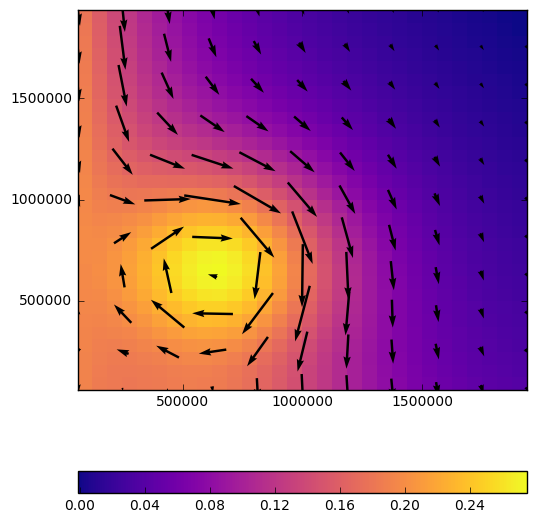

In [664]:
fig, ax = plt.subplots(1, 1, figsize=(5.8, 7))

Xs = np.arange(npts)*dx
Ys = np.arange(npts)*dx
X, Y = np.meshgrid(Xs, Ys)
mesh = ax.pcolormesh(X[1:, 1:], Y[1:, 1:], 
                     np.transpose(eta_next[1:, 1:]), cmap='plasma')
fig.colorbar(mesh, ax=ax, orientation='horizontal')
ax.set_xlim((dx, 31*dx))
ax.set_ylim((dx, 31*dx))
us, vs = unstagger(u_next, v_next)
ax.quiver(X[1::3, 1::3], Y[1::3, 1::3], np.transpose(us[::3, ::3]), np.transpose(vs[::3, ::3]),
               pivot='mid')

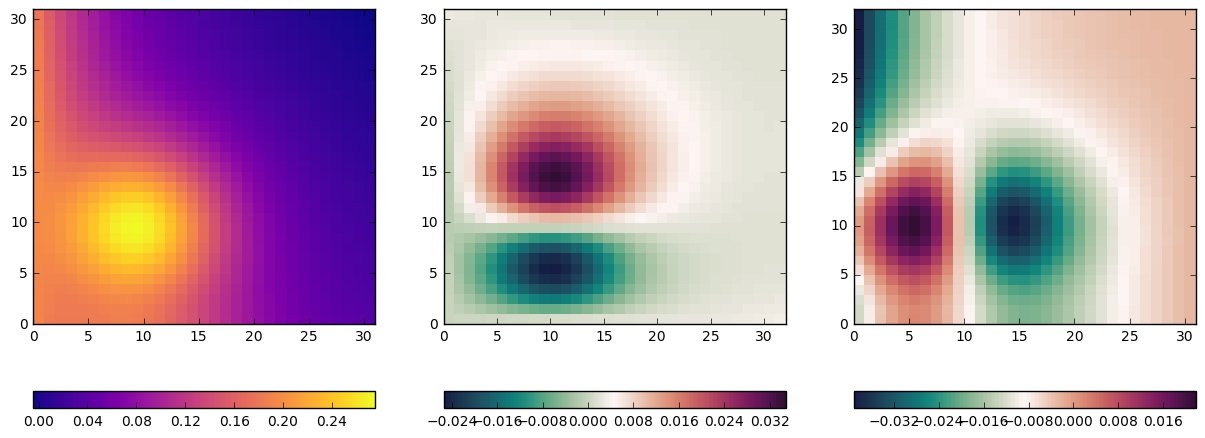

In [622]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5.8))
mesh = axs[0].pcolormesh(np.transpose(eta_next[1:, 1:]), cmap='plasma')
fig.colorbar(mesh, ax=axs[0], orientation='horizontal')
axs[0].set_xlim((0,31))
axs[0].set_ylim((0,31))
mesh = axs[1].pcolormesh(np.transpose(u_next[:, 1:]), cmap=cm.curl)
fig.colorbar(mesh, ax=axs[1], orientation='horizontal')
axs[1].set_xlim((0,32))
axs[1].set_ylim((0,31))
mesh = axs[2].pcolormesh(np.transpose(v_next[1:]), cmap=cm.curl)
fig.colorbar(mesh, ax=axs[2], orientation='horizontal')
axs[2].set_xlim((0,31))
axs[2].set_ylim((0,32));

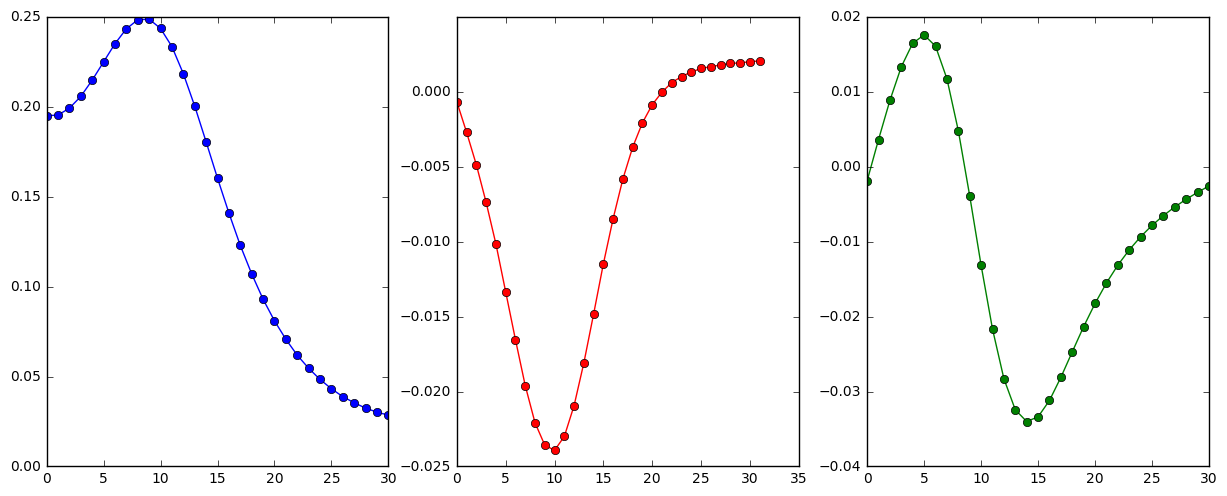

In [623]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5.8))
axs[0].plot(eta_next[1:, 7], 'bo-')
axs[1].plot(u_next[:, 7], 'ro-')
axs[2].plot(v_next[1:, 7], 'go-')

### My large scale wave ###
$\eta = \eta_o \sin(kx - \omega t)$

$k = 2\pi/(10 L)$

$c = \sqrt(gH)$

$\omega = c/k$

$\left( \frac {\partial^2}{\partial t^2} + f^2\right) u = - g \left( 
\frac {\partial^2 \eta}{\partial t \partial x} + f \frac{\partial \eta}{\partial y}\right)$

$\left( \frac {\partial^2}{\partial t^2} + f^2\right) v = - g \left( 
\frac {\partial^2 \eta}{\partial t \partial y} - f \frac{\partial \eta}{\partial x}\right)$



In [638]:
def incoming_wave(t, npts, dx):
    eta0 = 0.2
    wavenumber = 2*np.pi/(10*length)
    omega = wavespeed*wavenumber
    Xs = np.arange(npts)*dx
    Ys = np.arange(npts)*dx
    X, Y = np.meshgrid(Xs, Ys)
    eta_wave = eta0 * np.sin(wavenumber*Y - omega*t)
    u_wave = - g * eta0 * wavenumber * omega* np.sin(wavenumber*(Y + dx/2)  - omega*t) / (f*f -omega*omega)
    v_wave = g * eta0 * f * wavenumber * np.cos(wavenumber*Y - omega*t) / (f*f - omega*omega)
    return eta_wave, u_wave, v_wave

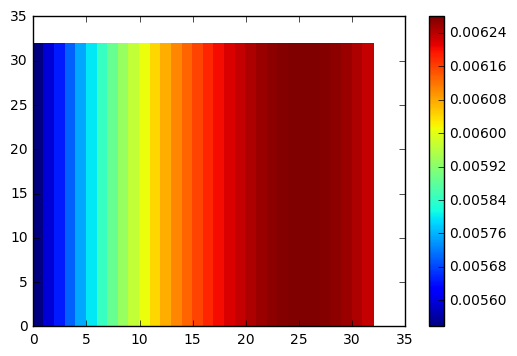

In [617]:
mywave, bwave, cwave = incoming_wave(100*dt, 32, dx)
plt.pcolormesh(cwave.transpose())
plt.colorbar()

In [618]:
# velocity vector plots
# FRS
# Flather

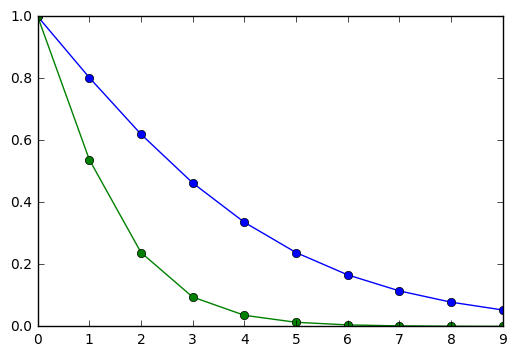

In [619]:
rim = 10.
plt.plot(1-np.tanh(2*np.arange(rim)/rim),'o-')
plt.plot(1.- np.tanh(( np.arange(rim) ) *0.5), 'o-' )

In [620]:
1.- TANH( FLOAT( nbr - 1 ) *0.5 )

NameError: name 'TANH' is not defined

In [624]:
def unstagger(ugrid, vgrid):
    """Interpolate u and v component values to values at grid cell centres.

    The shapes are the returned arrays are 1 less than those of
    the input arrays in the y and x dimensions.

    :arg ugrid: u velocity component values with axes (..., y, x)
    :type ugrid: :py:class:`numpy.ndarray`

    :arg vgrid: v velocity component values with axes (..., y, x)
    :type vgrid: :py:class:`numpy.ndarray`

    :returns u, v: u and v component values at grid cell centres
    :rtype: 2-tuple of :py:class:`numpy.ndarray`
        """
    u = np.add(ugrid[..., :-1], ugrid[..., 1:]) / 2
    v = np.add(vgrid[..., :-1, :], vgrid[..., 1:, :]) / 2
    return u[..., 1:, :], v[..., 1:]